# Autoencoder

Anomaly detection with autoencoder for the mnist dataset

In [38]:
import time
from collections import defaultdict

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# utility functions
def imshow(img) -> None:
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def count_parameters(model) -> int:
    """
    Returns number of trainable parameters in pt model
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [3]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [4]:
# training hyperparameters
batch_size = 32
test_batch_size = 1
lr = 1e-2         # learning rate
w_d = 1e-5        # weight decay
momentum = 0.9   
epochs = 15

In [5]:
# load dataset and dataloader
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5),
     transforms.Lambda(torch.flatten)])

trainset = torchvision.datasets.MNIST(root='./.data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./.data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=2)

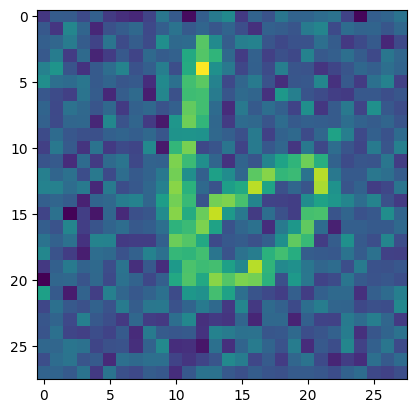

In [6]:
# display data
gaussian = AddGaussianNoise(0., 0.4)
imshow(gaussian(next(iter(trainloader))[0][0]).view(1, 28, 28))

In [7]:
# define autoencoder model
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU()
        )
    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

In [8]:
ae_model = AutoEncoder()
print(f"AE model has {count_parameters(ae_model)} trainable parameters")

AE model has 1154784 trainable parameters


In [9]:
metrics = defaultdict(list)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(ae_model.parameters(), lr=lr, weight_decay=w_d)

In [10]:
ae_model.to(device)

AutoEncoder(
  (enc): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=16, bias=True)
    (11): ReLU()
  )
  (dec): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=784, bias=True)
    (11): ReLU()
  )
)

## Train Autoencoder for reconstruction of all digits

In [11]:
ae_model.train()
start = time.perf_counter()

for epoch in range(epochs):
    ep_start = time.perf_counter()
    running_loss = 0.0
    for bx, (X, _) in enumerate(trainloader):
        X = X.to(device)
        optimizer.zero_grad()  # zero the parameter gradients

        # forward + backward + optimize
        X_reconstructed = ae_model(X)
        loss = criterion(X, X_reconstructed)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss/len(trainset)
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.perf_counter()

    print("-----------------------------------------------")
    print(f"Epoch {epoch+1}/{epochs}. Loss: {epoch_loss}")
    print(f"Epoch {epoch+1} took {ep_end - ep_start:.2f}s ")
end = time.perf_counter()
print("-----------------------------------------------")
print(f"Training Complete: {end-start:.2f}")

-----------------------------------------------
Epoch 1/15. Loss: 0.029060981729626654
Epoch 1 took 6.35s 
-----------------------------------------------
Epoch 2/15. Loss: 0.02892518563071887
Epoch 2 took 6.55s 
-----------------------------------------------
Epoch 3/15. Loss: 0.028919470312198003
Epoch 3 took 6.47s 
-----------------------------------------------
Epoch 4/15. Loss: 0.028918264022469522
Epoch 4 took 6.73s 
-----------------------------------------------
Epoch 5/15. Loss: 0.028917842799425126
Epoch 5 took 6.44s 
-----------------------------------------------
Epoch 6/15. Loss: 0.028917539338270824
Epoch 6 took 6.35s 
-----------------------------------------------
Epoch 7/15. Loss: 0.0289173538963
Epoch 7 took 6.43s 
-----------------------------------------------
Epoch 8/15. Loss: 0.028917227503657342
Epoch 8 took 6.49s 
-----------------------------------------------
Epoch 9/15. Loss: 0.028917155826091768
Epoch 9 took 6.41s 
-------------------------------------------

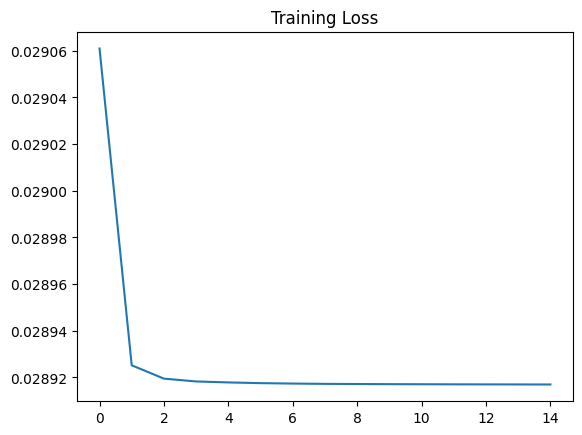

In [12]:
plt.title("Training Loss")
plt.plot(metrics['train_loss'])
plt.show()

## Test AE for anomaly detection on images with added noise

In [13]:
gaussian = AddGaussianNoise(0., 0.4)
ae_model.eval()

loss_dist = []
label_ids = []  # 1 is anomaly, 0 is normal

# shuffle should be set to false for testing data
for bx, (X, _) in enumerate(testloader):
    if np.random.rand() < 0.4:
        X = gaussian(X)
        label_ids.append(1)
    else:
        label_ids.append(0)
    X = X.to(device)
    X_reconstructed = ae_model(X)
    loss = criterion(X, X_reconstructed)
    loss_dist.append(loss.item())

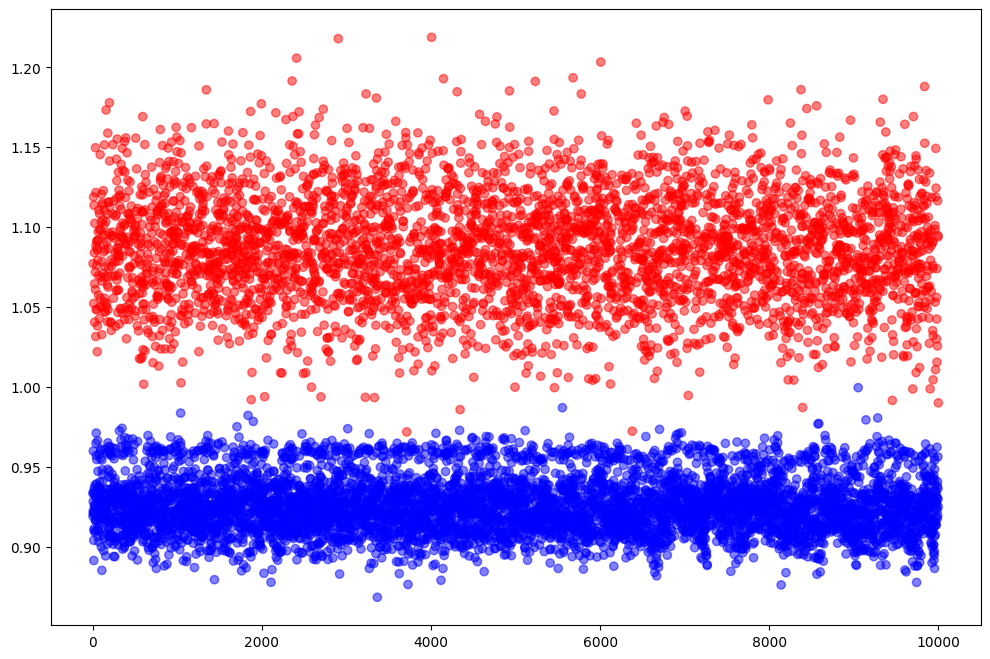

In [17]:
plt.figure(figsize=(12, 8))

color_list = ["blue" if label==0 else "red" for label in label_ids]

plt.scatter(range(len(loss_dist)), loss_dist, color=color_list, alpha=0.5)
plt.show()

<Figure size 1200x600 with 0 Axes>

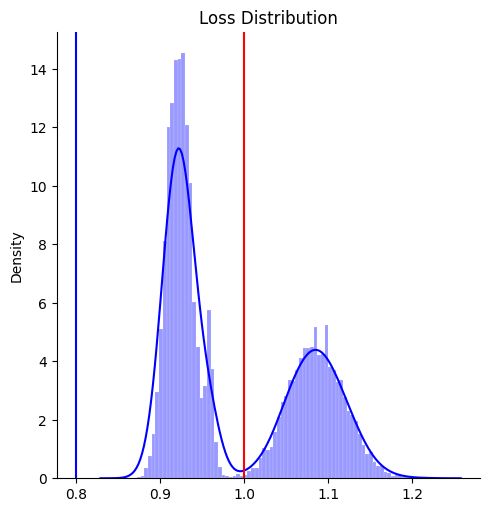

In [18]:
lower_threshold = 0.8
upper_threshold = 1.0
plt.figure(figsize=(12,6))
sns.displot(loss_dist, bins=80, kde=True, stat="density", 
            color='blue', kde_kws=dict(cut=3),
            alpha=.4, edgecolor=(1, 1, 1, .4),)
plt.title('Loss Distribution')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')
plt.show()

In [19]:
# evaluate anomaly classifier that uses the reconstruction loss and a threshold from our observations
thres = 1.0  # threshold is based on the figure above
pred_label_ids = [0 if loss < thres else 1 for loss in loss_dist]

In [20]:
tp, tn, fp, fn = 0, 0, 0, 0

for pred, target in zip(pred_label_ids, label_ids):
    if pred and target:
        tp += 1
    elif pred and not target:
        fp += 1
    elif not pred and target:
        fn += 1
    elif not pred and not target:
        tn += 1

In [21]:
print(f"Accuracy = {100 * (tp + tn) / (tp + tn + fp + fn)}%")
print(f"Precision = {100 * tp / (tp + fp)}%")
print(f"Recall = {100 * tp / (tp + fn)}%")

Accuracy = 99.83%
Precision = 100.0%
Recall = 99.57446808510639%


## Train Autoencoder for reconstruction of select digits in one class classification task

In [86]:
normal_digit = 6 # choose from [0, 9]

In [92]:
# training hyperparameters
batch_size = 32
lr = 3e-3         # learning rate
w_d = 1e-5        # weight decay
momentum = 0.9   
epochs = 75

In [88]:
ae_model_oc = AutoEncoder()
ae_model_oc.to(device)

AutoEncoder(
  (enc): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=16, bias=True)
    (11): ReLU()
  )
  (dec): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=784, bias=True)
    (11): ReLU()
  )
)

In [89]:
metrics = defaultdict(list)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(ae_model_oc.parameters(), lr=lr, weight_decay=w_d)

In [90]:
def filter_targets(data, digit=normal_digit):
    _, y = data
    return y == digit

In [91]:
filtered_trainset = list(filter(filter_targets, trainset))
filtered_trainloader = torch.utils.data.DataLoader(filtered_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [93]:
ae_model_oc.train()
start = time.perf_counter()

for epoch in range(epochs):
    ep_start = time.perf_counter()
    running_loss = 0.0
    for bx, (X, y) in enumerate(filtered_trainloader):
        X = X.to(device)
        optimizer.zero_grad()  # zero the parameter gradients

        # forward + backward + optimize
        X_reconstructed = ae_model_oc(X)
        loss = criterion(X, X_reconstructed)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss/len(trainset)
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.perf_counter()

    print("-----------------------------------------------")
    print(f"Epoch {epoch+1}/{epochs}. Loss: {epoch_loss}")
    print(f"Epoch {epoch+1} took {ep_end - ep_start:.2f}s ")
end = time.perf_counter()
print("-----------------------------------------------")
print(f"Training Complete: {end-start:.2f}")

-----------------------------------------------
Epoch 1/75. Loss: 0.002898601080973943
Epoch 1 took 2.87s 
-----------------------------------------------
Epoch 2/75. Loss: 0.002893316313624382
Epoch 2 took 2.66s 
-----------------------------------------------
Epoch 3/75. Loss: 0.0028885203033685684
Epoch 3 took 2.69s 
-----------------------------------------------
Epoch 4/75. Loss: 0.0028840273429950078
Epoch 4 took 2.65s 
-----------------------------------------------
Epoch 5/75. Loss: 0.0028798200418551764
Epoch 5 took 2.71s 
-----------------------------------------------
Epoch 6/75. Loss: 0.0028759736279646555
Epoch 6 took 2.52s 
-----------------------------------------------
Epoch 7/75. Loss: 0.0028723720173041024
Epoch 7 took 2.71s 
-----------------------------------------------
Epoch 8/75. Loss: 0.002868960623939832
Epoch 8 took 2.52s 
-----------------------------------------------
Epoch 9/75. Loss: 0.0028658198644717536
Epoch 9 took 2.63s 
-------------------------------

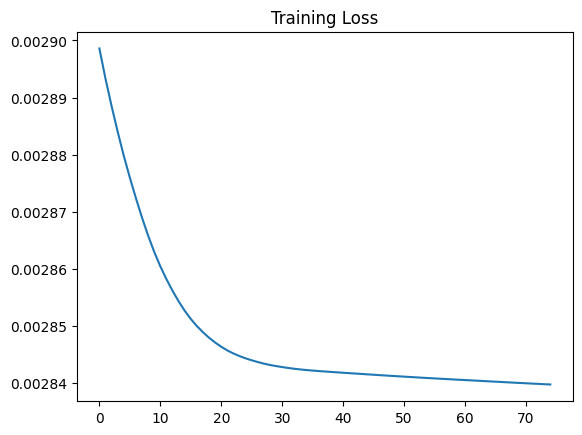

In [94]:
plt.title("Training Loss")
plt.plot(metrics['train_loss'])
plt.show()

## Test AE for one class classification

In [95]:
ae_model_oc.eval()

loss_dist = []
label_ids = []

# shuffle should be set to false for testing data
for bx, (X, y) in enumerate(testloader):
    label_ids.append(y)
    X = X.to(device)
    X_reconstructed = ae_model_oc(X)

    loss = criterion(X, X_reconstructed)
    loss_dist.append(loss.item())

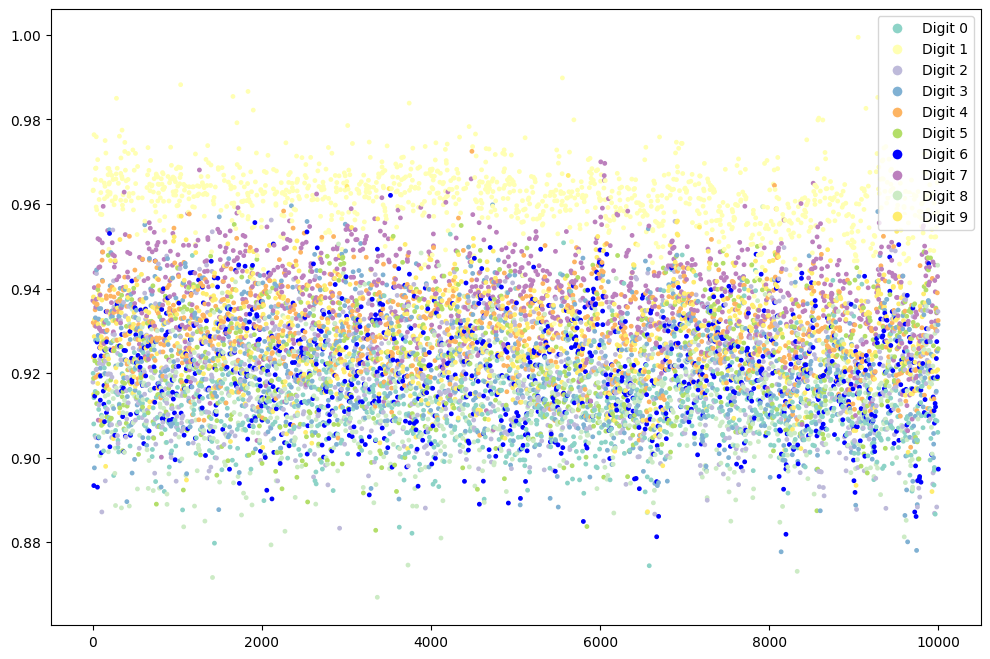

In [96]:
# loss_dist contains the loss values for data items
# label_ids contains the target values for the data items which is in the range [0, 9]
plt.figure(figsize=(12, 8))

cmap = cm.Set3(np.linspace(0, 1, 10))
cmap[normal_digit] = (0, 0, 1, 1)
color_list = [cmap[n] for n in label_ids]

plt.scatter(range(len(loss_dist)), loss_dist, color=color_list, s=6)

# Create legends for each digit
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap[n], markersize=8, label=f'Digit {n}')
                   for n in range(10)]

plt.legend(handles=legend_elements, loc='upper right')
plt.show()